# Creating housing archetypes using K-means method
### Q4 2020-21

## Introduction
This workbook will ...

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from kneed import KneeLocator 
from sklearn.datasets import make_blobs 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import ParameterGrid
from itertools import permutations
from itertools import combinations

## Data Source
The data represents a subset of ERS records used for initial analysis.

In [ ]:
ers_sample_records = pd.read_csv(r"C:\Users\owner\Documents\NRCan\code\practice\InitialHousingData.csv",)
ers_sample_records 

#original amount of obsevations/rows 
og_obs = ers_sample_records.shape[0]

In [ ]:
ers_sample_records

In [ ]:
ers_sample_records.describe()

## Database Preperation and Varibable Selection 


### Select variables for clustering
Placeholder for this process. 

In [ ]:
# Air50P selected for 1D clustering test
cl_variables = ['Main']
test_data = ers_sample_records[cl_variables]


### Missing values

In [ ]:
#Remove rows with blank values
test_data_cleaned = test_data.dropna()
#display how many rows removed
test_data_cleaned.describe()

###  Inconsistent data removal 
Dependant on the variable. Example: floor area could not be negavtive.


### Ensure all values are numerical
K-means can only handle numerical values. 

In [ ]:
# encode catagorical variables 


### Remove outliers

K-means is based off finding the mean of clusters and since means are senstive to outliers so is k-means. If outliers are not delt with the they can have a large infulence in the clustering porcess that could result in poor partiotns that are not representaive of the data. Because of this outliers need to be removed properly. 

Three different outlier removal techniques are tested: local outlier factor (LOF), z-score, and inter quartile range (IQR). 

The data will be interperated before and after outlier removal though box plots( and scatter?) and statisical measures.

In [ ]:
#box plot before outlier removal
test_data_cleaned.boxplot() 

#### Local outlier factor
Local outlier factor (LOF) values identify an outlier based on the local neighborhood. It gives better results than the global approach to find outliers. A point will be considered as an outlier if it is at a small distance to the extremely dense cluster. 

In [ ]:
#define the model

lof = LocalOutlierFactor()
lof_pred = lof.fit_predict(test_data_cleaned) 

#extract the negative outputs as the outliers.
mask = lof_pred != -1

#remove rows with outliers 
lof_data = test_data_cleaned[mask] #i dont think this works for sets with more than 1 varibale
print([lof_data])

#print amount of points deleated

outliers_rem = og_obs - lof_data.shape[0]
print ('amount of outliers removed: %d' %outliers_rem )

#plot without after removal

lof_data.boxplot()

#### Z-score 

In [ ]:
#find absolute value of z-score for each observation
z = np.abs(stats.zscore(test_data_cleaned))

#only keep rows in dataframe with all z-scores less than absolute value of 3 
z_data = test_data_cleaned[(z<3).all(axis=1)]

#print amount of outliers removed
z_data

outliers_rem = og_obs - z_data.shape[0]
print ('amount of outliers removed: %d' %outliers_rem )

In [ ]:
#plotafter outlier removal
z_data.boxplot()

#### IQR
The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5 (used below). A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots.

In [ ]:
#find Q1, Q3, and interquartile range for each column
Q1 =test_data_cleaned.quantile(q=.25)
Q3 = test_data_cleaned.quantile(q=.75)
IQR =test_data_cleaned.apply(stats.iqr)

#only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
iqr_data = test_data_cleaned[~((test_data_cleaned < (Q1-1.5*IQR)) | (test_data_cleaned > (Q3+1.5*IQR))).any(axis=1)]

#print amount of outliers removed

outliers_rem = og_obs - iqr_data.shape[0]
print ('amount of outliers removed: %d' %outliers_rem )

In [ ]:
#plot of IQR outlier removal
iqr_data.boxplot()


 Mahalanobis distance - calc when multi variabale later
 https://www.statology.org/mahalanobis-distance-python/

### Clustering
Find the best mix of parameters for clustering. Parameters include oulier removal, scaling, initalization, and k.

In [ ]:
#import validation metrics 
#could also use package validclust
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, davies_bouldin_score)

In [ ]:
# create sets of pre-processed data ready for clustering 
scaled_data_sets = [iqr_data,lof_data, z_data]


In [ ]:
#list of scalers
standard = StandardScaler()
minimax = MinMaxScaler()
scalers = [standard, minimax]
#list of initalizers 
r = 'random'
plus = 'k-means++' 
initalizer = [r, plus]



In [ ]:
# datasets being transfromed with standard scaler and random init
standard_rand_in=[]
standard_rand_cal=[]
standard_rand_dav=[]
standard_rand_sil=[]

for x in range(len(scaled_data_sets)):
    #first set of data to scale
    scaled_features = scalers[0].fit_transform(scaled_data_sets[x]) #not going to work for if sets change
   
    #determine amount of clusters elbow elblw method
    
    sse=[] #determine SSE for 1 to 11 clusters
    
    kmeans_kwargs = {
    "init":"random",  #for random 
    "n_init":10, 
    "max_iter":300,
    "random_state":42,}
    
    for k in range(1,11): #pre determined amount
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    k1 = KneeLocator(range(1,11),sse,curve="convex", direction="decreasing")
    clamount=k1.elbow
    
    #cluster with amount of clusters 
    
    kmeans = KMeans(
    init="random",
    n_clusters= clamount,
    n_init=10,
    max_iter=300,
    random_state=42)
    
    kmeans.fit(scaled_features)
    
    standard_rand_in.append(kmeans.inertia_) # can use other validations too 
    
    pred_labels = kmeans.labels_
    
    sil = silhouette_score(scaled_data_sets[x], pred_labels)
    cal_score = calinski_harabasz_score(scaled_data_sets[x], pred_labels)
    dav_score = davies_bouldin_score(scaled_data_sets[x], pred_labels)
    
    standard_rand_cal.append(cal_score)
    standard_rand_dav.append(dav_score)
    standard_rand_sil.append(sil)

In [ ]:
#datasets being transfromed with mini scaler and random init
mini_rand_in=[]
mini_rand_cal=[]
mini_rand_sil=[]
mini_rand_dav=[]
for x in range(len(scaled_data_sets)):
    #first set of data to scale
    scaled_features = scalers[1].fit_transform(scaled_data_sets[x]) #not going to work for if sets change
   
    #determine amount of clusters elbow elblw method
    
    sse=[] #determine SSE for 1 to 11 clusters
    
    kmeans_kwargs = {
    "init":"random",  #for random 
    "n_init":10, 
    "max_iter":300,
    "random_state":42,}
    
    for k in range(1,11): #pre determined amount
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    k1 = KneeLocator(range(1,11),sse,curve="convex", direction="decreasing")
    clamount=k1.elbow
    
    #cluster with amount of clusters 
    
    kmeans = KMeans(
    init="random",
    n_clusters= clamount,
    n_init=10,
    max_iter=300,
    random_state=42)
    
    kmeans.fit(scaled_features)
   
    #validation metrics 
    
    mini_rand_in.append(kmeans.inertia_) # can use other validations too 
   
    pred_labels = kmeans.labels_
    
    sil = silhouette_score(scaled_data_sets[x], pred_labels)
    cal_score = calinski_harabasz_score(scaled_data_sets[x], pred_labels)
    dav_score = davies_bouldin_score(scaled_data_sets[x], pred_labels)

    mini_rand_cal.append(cal_score)
    mini_rand_sil.append(sil)
    mini_rand_dav.append(dav_score)

In [ ]:
#datasets being transfromed with mini scaler and k++ init

mini_plus_in=[]
mini_plus_cal=[]
mini_plus_sil=[]
mini_plus_dav=[]

for x in range(len(scaled_data_sets)):
    #first set of data to scale
    scaled_features = scalers[1].fit_transform(scaled_data_sets[x]) #not going to work for if sets change
   
    #determine amount of clusters elbow elblw method
    
    sse=[] #determine SSE for 1 to 11 clusters
    
    kmeans_kwargs = {
    "init":"k-means++",  #for random 
    "n_init":10, 
    "max_iter":300,
    "random_state":42,}
    
    for k in range(1,11): #pre determined amount
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    k1 = KneeLocator(range(1,11),sse,curve="convex", direction="decreasing")
    clamount=k1.elbow
    
    #cluster with amount of clusters 
    
    kmeans = KMeans(
    init="k-means++",
    n_clusters= clamount,
    n_init=10,
    max_iter=300,
    random_state=42)
    
    kmeans.fit(scaled_features)
    
    mini_plus_in.append(kmeans.inertia_) # can use other validations too 
    
    pred_labels = kmeans.labels_
    
    sil = silhouette_score(scaled_data_sets[x], pred_labels)
    cal_score = calinski_harabasz_score(scaled_data_sets[x], pred_labels)
    dav_score = davies_bouldin_score(scaled_data_sets[x], pred_labels)
  
    mini_plus_cal.append(cal_score)
    mini_plus_sil.append(sil)
    mini_plus_dav.append(dav_score)
    

  

In [ ]:
#datasets being transfromed with standard scaler and k++ init

standard_plus_in=[]
standard_plus_cal=[]
standard_plus_dav=[]
standard_plus_sil=[]


for x in range(len(scaled_data_sets)):
    #first set of data to scale
    scaled_features = scalers[0].fit_transform(scaled_data_sets[x]) #not going to work for if sets change
   
    #determine amount of clusters elbow elbow method
    
    sse=[] #determine SSE for 1 to 11 clusters
    
    kmeans_kwargs = {
    "init":"k-means++",  #for random 
    "n_init":10, 
    "max_iter":300,
    "random_state":42,}
    
    for k in range(1,11): #pre determined amount
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    k1 = KneeLocator(range(1,11),sse,curve="convex", direction="decreasing")
    clamount=k1.elbow
    
    #cluster with amount of clusters 
    
    kmeans = KMeans(
    init="k-means++",
    n_clusters= clamount,
    n_init=10,
    max_iter=300,
    random_state=42)
    
    kmeans.fit(scaled_features)
    
    standard_plus_in.append(kmeans.inertia_) # can use other validations too 
     
    pred_labels = kmeans.labels_
    
    sil = silhouette_score(scaled_data_sets[x], pred_labels)
    cal_score = calinski_harabasz_score(scaled_data_sets[x], pred_labels)
    dav_score = davies_bouldin_score(scaled_data_sets[x], pred_labels)
    
    standard_plus_cal.append(cal_score)
    standard_plus_dav.append(dav_score)
    standard_plus_sil.append(sil)
  

In [ ]:
#intertia results
results_inertia = pd.DataFrame({ 'st rand':standard_rand_in, 'st plus':standard_plus_in,'min rand':mini_rand_in, 'min plus': mini_plus_in}, index= ['IRQ','LOF','Z-score'])
results_inertia


In [ ]:
#DB results(Values closer to zero indicate a better partition.)
results = pd.DataFrame({ 'st rand':standard_rand_dav, 'st plus':standard_plus_dav,'min rand':mini_rand_dav, 'min plus': mini_plus_dav}, index= ['IRQ','LOF','Z-score'])
results

In [ ]:
#sil results (want higher=highly dense clustering)
results = pd.DataFrame({ 'st rand':standard_rand_sil, 'st plus':standard_plus_sil,'min rand':mini_rand_sil, 'min plus': mini_plus_sil}, index= ['IRQ','LOF','Z-score'])
results

In [ ]:
#cal results(want higher)
results = pd.DataFrame({ 'st rand':standard_rand_cal, 'st plus':standard_plus_cal,'min rand':mini_rand_cal, 'min plus': mini_plus_cal}, index= ['IRQ','LOF','Z-score'])
results

## Result visualization 
Visulaizing the results of the nest method determined above.

LOF outlier ommision, MinMax scaling, elbow method k determination, k-means++ initalization. Independant od Clustering performed above.

In [ ]:
#data
data = lof_data
data.describe()

In [ ]:
#merging original data with cleaned data for plotting realtionships later
lof_data_full = pd.merge(data, ers_sample_records, right_index=True, left_index =True) 
lof_data_full
lof_data_full = lof_data_full.drop(columns=['Rating_x'])
#re-setting index for mergeing with cluster lables later
data_all = lof_data_full
data_all = data_all.reset_index(drop=True)
data_all


In [ ]:
# scatter plot before clustering to look for intutive clusters 
sns.pairplot(data_all)

In [ ]:
#scaling with MinMax scaler
minmax = MinMaxScaler()
scaled_features = minmax.fit_transform(data)
#scaled feature into a data frame 
scaled_features = pd.DataFrame(scaled_features)

In [ ]:
#compare Stats for scaled and unsclaed data
#show scaled stats
scaled_features.describe()

In [ ]:
#show unscaled stats
data.describe()

In [ ]:
#plot histogram of scaled feaures 
scaled_features.hist(bins=10)

In [ ]:
# before scaling histogram
data.hist(bins=10)

In [ ]:
#clustering

kmeans_kwargs = {
    "init":"k-means++", 
    "n_init":10, 
    "max_iter":300,
    "random_state":42,}

sse=[] #determine SSE for 1 to 11 clusters    
for k in range(1,11): 
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
        
#plot elbow method
plt.style.use("fivethirtyeight")
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
        
k1 = KneeLocator(range(1,11),sse,curve="convex", direction="decreasing")
clamount=k1.elbow
    
#cluster with k determined above 
    
kmeans = KMeans(
    init="k-means++",
    n_clusters= clamount,
    n_init=10,
    max_iter=300,
    random_state=42)

In [ ]:
# create a dataframe including all variabels and cluster labels 
kmeans.fit(scaled_features)
labels = pd.DataFrame(kmeans.labels_,columns=['cluster label'])

cluster1=pd.concat([labels,data_all], axis = 1) 

cluster1

Looking at clusters individually 

In [ ]:
#cluster 0 dataframe
cluster_0 = cluster1.loc[cluster1['cluster label'] == 0, ['MainWallIns_y']]
cluster_0 = cluster_0.rename(columns={'MainWallIns_y': 'Cluster 0'})
# can view boxplot and stats separate but easier to compare on same table see below 
#cluster_0.boxplot()
#cluster_0.describe()

In [ ]:
#cluster 1 dataframe
cluster_1 = cluster1.loc[cluster1['cluster label'] == 1, ['MainWallIns_y']]
cluster_1=cluster_1.rename(columns={'MainWallIns_y': 'Cluster 1'})
#cluster_1.boxplot()
#cluster_1.describe()

In [ ]:
#cluster 2 dataframe
cluster_2 = cluster1.loc[cluster1['cluster label'] == 2, ['MainWallIns_y']]
#cluster_2.boxplot()
#cluster_2.describe()

In [ ]:
#cancatinate blox plot for each cluster to compare variation they capture for the certain vairbale 
#concatinate into a data frame 
all_clust = pd.concat([cluster_0,cluster_1, cluster_2], ignore_index=True, axis=1)
#plot using pandas 
all_clust.boxplot()

In [ ]:
#comparison of all cluster stats 
all_clust.describe()

In [ ]:
#Cluser Centroids 

centroids = minmax.inverse_transform(kmeans.cluster_centers_) # transform scaled cenroids back

centroids

In [ ]:
#Scatter plot of custers not scaled 
sns.scatterplot('MainWallIns_y', 'YearBuilt', data=cluster1, hue= 'cluster label')

In [ ]:
#scatter plot of scaled values 

# create a dataframe including all variabels and cluster labels 
kmeans.fit(scaled_features)
labels = pd.DataFrame(kmeans.labels_,columns=['cluster label'])

data_all_scaled = pd.DataFrame(minmax.fit_transform(data_all), columns = [ 'Air50P', 'Rating', 'YearBuilt', 'FloorArea',
       'MainWallIns_y'])

clusters_scaled = pd.concat([labels, data_all_scaled], axis = 1) 
sns.pairplot(clusters_scaled, hue = 'cluster label')

In [ ]:
# plot all varibles (not scaled) against eachother to find patterns in clusters  
sns.pairplot(cluster1, hue='cluster label')

In [ ]:
#silhouette coefficent visualizer
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(scaled_features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
#In SilhouetteVisualizer plots, clusters with higher scores have wider silhouettes, but clusters 
#that are less cohesive will fall short of the average score across all clusters, which is plotted as a
#vertical dotted red line.

In [ ]:
#inter cluster distance maps
from yellowbrick.cluster import InterclusterDistance

visualizer = InterclusterDistance(kmeans)

visualizer.fit(scaled_features)    # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
#the closer to centers are in the visualization, the closer they are in the original feature space.

## 2D clustering 
This area is completely separate from above 1D clustering.

### Data preping 
Fist the data is retrieved and preped. Missing data is removed because k-means does not accept missing values and outliers are also removed because K-means is sensitive to outliers (a mean is easily influenced by extreme value). The preping will help acheive more robust clusting results. 

In [ ]:
#retreive data
ers_sample_records = pd.read_csv(r"C:\Users\owner\Documents\NRCan\code\practice\InitialHousingData.csv",)
ers_sample_records 

#original amount of obsevations/rows 
og_obs = ers_sample_records.shape[0]

In [ ]:
#retrive data from above
ers_sample_records


Two variables are selected fo perform clustering on. 

In [ ]:
#select variables for 2D clustering 
cl_variables = ['YearBuilt', 'Rating'] # for automation of code (hasn't been done yet)
twoD_data = ers_sample_records[cl_variables] # a varible towD_data is created to hold clustering varibles specifcally for 2D analysis 
twoD_data

In [ ]:
#review raw data stats 
twoD_data.describe()

Cleaning data. Dropna from pandas is used to remove rows were at least on element is na and local outlier factor is applied for outlier detection. 


In [ ]:
#Drop the rows where at least one element is NA.
twoD_data_clean = twoD_data.dropna()
removed = len(twoD_data)-len(twoD_data_clean)
#print amount of rows removed 
print('rows of data dropped:%d' %removed )

Local outlier factor (LOF) values identify an outlier based on the local neighborhood. It gives better results than the global approach to find outliers. A point will be considered as an outlier if it is at a small distance to the extremely dense cluster. 

In [ ]:
#plot varation with box plots before outlier removal to visualize outliers 
twoD_data.boxplot()

In [ ]:
#define the model

lof = LocalOutlierFactor(n_neighbors=20)
lof_pred = lof.fit_predict(twoD_data_clean) 

#extract the negative outputs as the outliers.
mask = lof_pred != -1

#remove rows with outliers 
lof_data = twoD_data_clean[mask] #i dont think this works for sets with more than 1 varibale

#print amount of points deleated

outliers_rem = og_obs - lof_data.shape[0]
print ('amount of outliers removed: %d' %outliers_rem )

#plot without after removal to visualize outlier removal

lof_data.boxplot() 

#should scale and plot as they have very different scales 

Also can visualize outlier remvial though a scatter plot. The red values are the outliers that have been removed. 

In [ ]:
# create a dataframe of removed outliers for plotting 
from numpy import where
lofs_index = where(lof_pred==-1) 
#Filter_df  = twoD_data_clean[twoD_data_clean.index.isin(lofs_index)]
outliers =twoD_data_clean.loc[lofs_index] #datarfame of outliers 
#could write a check here: len of oultleris == outliers rem

In [ ]:
plt.scatter(twoD_data_clean['Air50P'], twoD_data_clean['MainWallIns'])

In [ ]:
#plot removed outliers in red
plt.scatter(twoD_data_clean['Air50P'], twoD_data_clean['MainWallIns'])
plt.scatter(outliers['Air50P'],outliers['MainWallIns'], color='r')
plt.show()

Compare cleaned data stats to raw data to confirm the data is still meaningful. 

In [ ]:
#stats after outlier removal 
lof_data.describe()

In [ ]:
twoD_data.describe()

### Scaling 
k-means is distance based so for it to consider all attributes as equal and produce unbiased resutls, they must all have the same scale.

Min-max scaling rescales the data into a given range, in this case 0-1. 

In [ ]:
minmax = MinMaxScaler()
scaled_features = minmax.fit_transform(lof_data)

### Clustering 
In this step the preped data is clustered with the k-means algorithm. K-means++ is used for inialization and the amount of clusters is determined with internal validity measures.

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
# within cluster SSe (aka distortion)
#Distortion is the average of the euclidean squared distance from the centroid of the respective clusters. 
#Inertia is the sum of squared distances of samples to their closest cluster centre
model = KMeans(
    init="k-means++",
    n_init=10,
    max_iter=300,
    random_state=42)

#plot elbow method with distortion score

visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(lof_data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

#plot elbow method Calinski Harabasz 

visualizer = KElbowVisualizer(model, k=(2,10),metric='calinski_harabasz')

visualizer.fit(lof_data)        # Fit the data to the visualizer
visualizer.show()    

#plot elbow method with silhouette score 

visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette')

visualizer.fit(lof_data)        # Fit the data to the visualizer
visualizer.show()    

In [ ]:


# plot elbow method with inertia/WSS/SSE

sse=[] #determine SSE for 1 to 11 clusters, SSE = WSS
kmeans_kwargs = {
    "init":"k-means++",
    "n_init":10, 
    "max_iter":300,
    "random_state":42,
}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
 
plt.style.use("fivethirtyeight")
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
#find the elbow/k
k1 = KneeLocator(
    range(1,11),sse,curve="convex", direction="decreasing")
k1.elbow

In [ ]:

from sklearn.metrics import davies_bouldin_score

DB_score = []

kmeans_kwargs = {
    "init":"k-means++",
    "n_init":10, 
    "max_iter":300,
    "random_state":42,
}

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    pred_labels = kmeans.labels_
    dav_score = davies_bouldin_score(scaled_features, pred_labels)
    DB_score.append(dav_score)
   
plt.style.use("fivethirtyeight")
plt.plot(range(2,11), DB_score)
plt.xticks(range(2,11))
plt.xlabel("Number of Clusters")
plt.ylabel("DB")
plt.show()

#find min BD = optimum K


In [ ]:
#amount of clusters for DB
min_index = DB_score.index(min(DB_score))
DB_k =range(2,11)
DB_k = DB_k[min_index]
DB_k 

After the optimal k vlaue the clustering algortihm is ran once more and resulting clusters can be analyzed. 

In [ ]:
#final k-means arguments 
kmeans = KMeans(
    init="k-means++",
    n_clusters=3, #change k value here
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(scaled_features)
labels = pd.DataFrame(kmeans.labels_,columns=['label']) #creating a dataframe to house cluster labels for each house
centroids = kmeans.cluster_centers_ #creating varible to hold centroid values 
centroids_real = minmax.inverse_transform(centroids) #also mean of cluster
kmeans.inertia_

In [ ]:
lof_data_new_index = lof_data.reset_index(drop=True) #new index to allow concatination to line up properly 

clusters = pd.concat([labels,lof_data_new_index], axis = 1) #can concatanate along columns but enssure that indicies are the same
#using groupby to compare clustering results 
label_group = clusters.groupby(['label']) #make varible for lable groups

label_group.get_group(1) #retrieve data frame of group

In [ ]:
#using group by to get median and means(cenroids) of the resulting clusters 
label_group['FloorArea'].agg(['mean','median'])

In [ ]:
#geting mean and median for just one cluster 
label_group['Air50P'].agg(['mean','median'])

In [ ]:
#stats for all clusters by varible 
label_group.describe() 

In [ ]:
#scaling data for plotting
scaled_clusters = clusters.copy() #create a copy so that origonal not lost or modified 
scaled_clusters[['YearBuilt','Rating']] = minmax.fit_transform(scaled_clusters[['YearBuilt','Rating']]) #put in the cl_varibles or whatever to make it automated
#scaled_clusters

In [ ]:
#plot with centroids
ax=sns.scatterplot(y=scaled_clusters.columns[2],x= scaled_clusters.columns[1], data=scaled_clusters, hue= 'label')
ax=sns.scatterplot(y=centroids[:,1],x=centroids[:,0], s=40, ec='black', legend=False, ax=ax)
plt.show()

In [ ]:
#plot without centroids and  not scaled 
sns.scatterplot(y='YearBuilt',x= 'Air50P', data=clusters, hue= 'label')


Plot comparion of all variables

# Larger than 2D clustering 

## Data source 
The data represents a subset of the ERS records. 

In [4]:
ers_sample_records = pd.read_csv(r"C:\Users\owner\Documents\NRCan\code\practice\InitialHousingData.csv",)
ers_sample_records 


,Air50P,Rating,YearBuilt,FloorArea,MainWallIns
0,8.77,60.0,1930,129.9,1.57
1,13.96,24.0,1908,447.0,0.85
2,5.19,75.0,1989,183.1,2.60
3,12.41,56.0,1950,110.5,1.84
4,5.38,71.0,1972,172.9,3.11
...,...,...,...,...,...
9626,19.61,0.0,1910,183.8,1.80
9627,11.94,0.0,1900,149.5,2.71
9628,7.85,0.0,1985,177.8,2.95
9629,8.13,0.0,1990,137.0,2.84


In [5]:
ers_sample_records.describe()

,Air50P,Rating,YearBuilt,FloorArea,MainWallIns
count,9631.000000,9631.000000,9631.000000,9631.000000,9631.000000
mean,7.593068,64.476981,1973.530371,174.021213,2.132177
std,3.651897,12.342700,23.887898,47.600877,0.541872
min,0.470000,-32.000000,1800.000000,47.200000,0.000000
25%,5.410000,62.000000,1968.000000,145.600000,1.820000
50%,6.700000,67.000000,1980.000000,167.300000,2.020000
75%,8.670000,72.000000,1989.000000,193.300000,2.610000
max,51.920000,83.000000,2015.000000,1616.200000,4.860000


## Data Preparation

Remove missing houses (rows) that have missing data in at least one cloumn.

In [6]:
#Drop the rows where at least one element is NA.
cleaned_data = ers_sample_records.dropna()
removed = len(ers_sample_records )-len(cleaned_data)
#print amount of rows removed 
print('rows of data dropped:%d' %removed )

rows of data dropped:0


Remove houses (rows) that have inconsistent data. The definition of inconsistent depends on the varible, ensure to change this area when using a new dataset. 

In [7]:
#input bounds for each paramter
filt_data = cleaned_data[cleaned_data['Air50P'] > 0]
filt_data = filt_data[filt_data['Rating'] > 0]
filt_data = filt_data[filt_data['YearBuilt'] > 0]
filt_data = filt_data[filt_data['FloorArea'] > 0]
filt_data = filt_data[filt_data['MainWallIns'] > 0]

#print amount of rows removed 
removed = len(cleaned_data )-len(filt_data)
print('rows of data dropped:%d' %removed )

rows of data dropped:85


### Outiler Removal 
Local outlier factor algorithm detects the outliers and they are subsequently removed. 

In [120]:
#define the model

lof = LocalOutlierFactor(n_neighbors=20)
lof_pred = lof.fit_predict(filt_data) 

#extract the negative outputs as the outliers.
mask = lof_pred != -1

#remove rows with outliers 
lof_data = filt_data[mask] #i dont think this works for sets with more than 1 varibale

#print amount of points deleated

outliers_rem = len(filt_data) - lof_data.shape[0]
print ('Outliers removed: %d' %outliers_rem )



Outliers removed: 357


To visualize the outlier removal the parameters are scaled using standardscaler(z-score) so that they can be compared on the same axes then plotted with boxplots. 

<AxesSubplot:>

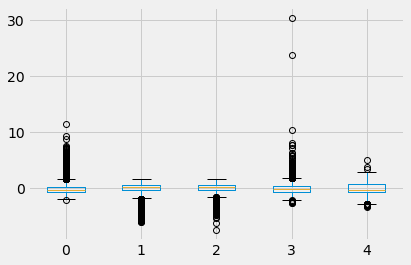

In [30]:
#inintalize scaler 
scaled = StandardScaler()

#scale filtered data in preparation for plotting 
scaled_filt_data = pd.DataFrame(scaled.fit_transform(filt_data))

#plot boxplots before outlier removal

scaled_filt_data.boxplot()

<AxesSubplot:>

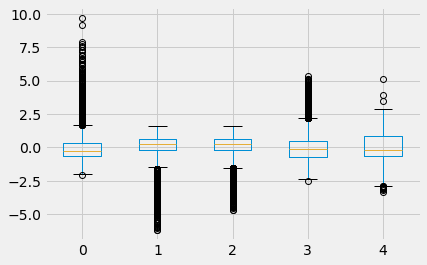

In [31]:
#scale data with outliers removed in preparation for plotting

scaled_parameters = scaled.fit_transform(lof_data)
scaled_parameters = pd.DataFrame(scaled_parameters)

#plot boxplots after outlier removal
scaled_parameters.boxplot()

## Parameter selection 
The minimal amount of paramters that represent the building stock data effectively are selected to be clustered. The parameters that are not selected are removed. 

In [33]:
#insert the column name of the selected parameters that will be held by the varibale parameters
parameters = ['Air50P','Rating', 'YearBuilt', 'FloorArea', 'MainWallIns']
# create a new data frame with parameters 
cl_data = lof_data[parameters]

 categorically filter?

### Parameter scaling 
K-means is distance based so for it to consider all attributes as equal and produce unbiased resutls, they must all have the same scale. Minmax scaling rescales the data into a given range (0-1), this method was chosen from earlier 1D/2D clustering. 

In [34]:
#initalize scaler
minmax = MinMaxScaler()
#scale parameters
scaled_parameters = minmax.fit_transform(cl_data)


## K-means clustering 

###  Optmial cluster amout determination
Davies Bouldin score is used to determine the optimal amount of clusters for the data. The DB score is calculated for a range of k-values (2-11) and the k-value that gives the lowest DB score is optimal. This is then used as an input for the k-means clustering.

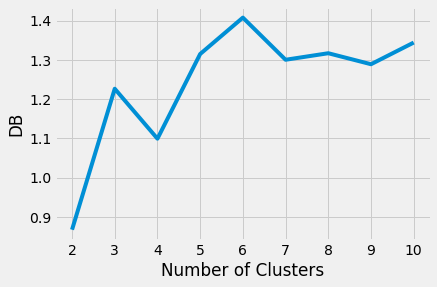

2

In [121]:
from sklearn.metrics import davies_bouldin_score

DB_score = []

kmeans_kwargs = {
    "init":"k-means++",
    "n_init":10, 
    "max_iter":300,
    "random_state":42,
}

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_parameters)
    pred_labels = kmeans.labels_
    dav_score = davies_bouldin_score(scaled_parameters, pred_labels)
    DB_score.append(dav_score)
   
plt.style.use("fivethirtyeight")
plt.plot(range(2,11), DB_score)
plt.xticks(range(2,11))
plt.xlabel("Number of Clusters")
plt.ylabel("DB")
plt.show()

#find min BD = optimum K

#amount of clusters for DB
min_index = DB_score.index(min(DB_score))
DB_k =range(2,11)
DB_k = DB_k[min_index]
DB_k 

### Clustering 
The prepared data is now clustered using the opitmal amount of clusters found in the past step as the n_clusters argument.

In [50]:

kmeans = KMeans(
    init="k-means++",
    n_clusters=DB_k,
    n_init=10,
    max_iter=300,
    random_state=42)

kmeans.fit(scaled_parameters)
labels = pd.DataFrame(kmeans.labels_,columns=['label']) #creating a dataframe to house cluster labels for each house
centroids = kmeans.cluster_centers_ #creating varible to hold centroid values (scaled) 
centroids_real = minmax.inverse_transform(centroids) #centriods with non-scaled values 

A new dataframe is created adding a column 'label' to show the rows corresponding cluster label decided during k-means clustering. This will allow the resulting paritions to be viewed easier.

In [51]:
cl_data_new_index = cl_data.reset_index(drop=True) #new index to allow concatination to line up properly 
#can concatanate along columns but ensure that indicies are the same
clusters = pd.concat([labels,cl_data_new_index], axis = 1) 
#make varible for label groups
label_group = clusters.groupby(['label']) 

### Result statisics 
The statisics are a way to evalute the results numerically. 

The amount of objects (houses) in each cluster. 

In [124]:
label_group.count()

,Air50P,Rating,YearBuilt,FloorArea,MainWallIns
label,,,,,
0,8132,8132,8132,8132,8132
1,1057,1057,1057,1057,1057


The mean(centroid), standard deviation, and range for each clusters and parameter. Smaller std mean tighter clusters (more compact).

In [126]:
label_group.agg(['mean','std','min', 'max'])

Air50P                            Rating                         \
            mean       std   min    max       mean        std   min   max   
label                                                                       
0       6.698184  2.087193  0.47  20.74  68.032759   5.556754  43.0  82.0   
1      13.289593  5.451863  2.91  40.70  44.367077  13.639000   2.0  74.0   

         YearBuilt                          FloorArea                          \
              mean        std   min   max        mean        std   min    max   
label                                                                           
0      1981.001599  11.734828  1925  2012  172.440753  38.880757  77.4  387.3   
1      1920.507096  20.135907  1865  1974  183.484579  56.517041  70.4  393.9   

      MainWallIns                        
             mean       std   min   max  
label                                    
0        2.243949  0.439735  0.56  4.86  
1        1.362895  0.547769  0.37  3.32

The centriods values for each parameter. These represent the arcetypes characterisicts. 

In [57]:
#centroids 

centroids_real = pd.DataFrame(centroids_real, columns = [parameters])
centroids_real2 = centroids_real.reset_index()
centroids_real2= centroids_real2.rename(columns = {"index" : "label"})
centroids_real2

,label,Air50P,Rating,YearBuilt,FloorArea,MainWallIns
0,0,6.697871,68.034731,1981.004796,172.444054,2.244009
1,1,13.285766,44.374291,1920.539698,183.448771,1.363261


### Visualize results 

Parallel coordinates colour coded by cluster label help to comprehend the distribution of each cluster and how distict the clusters are. 

In [122]:
import plotly.express as px

fig = px.parallel_coordinates(clusters, color="label", 
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()


Box plots for each parameter also show how much overlap there is between clusters for each parameter and how compact each cluster is. IF the IQR of each cluster are not offset they are not distinct. The smaller the IQR and whiskers are the more compact the cluster is. 

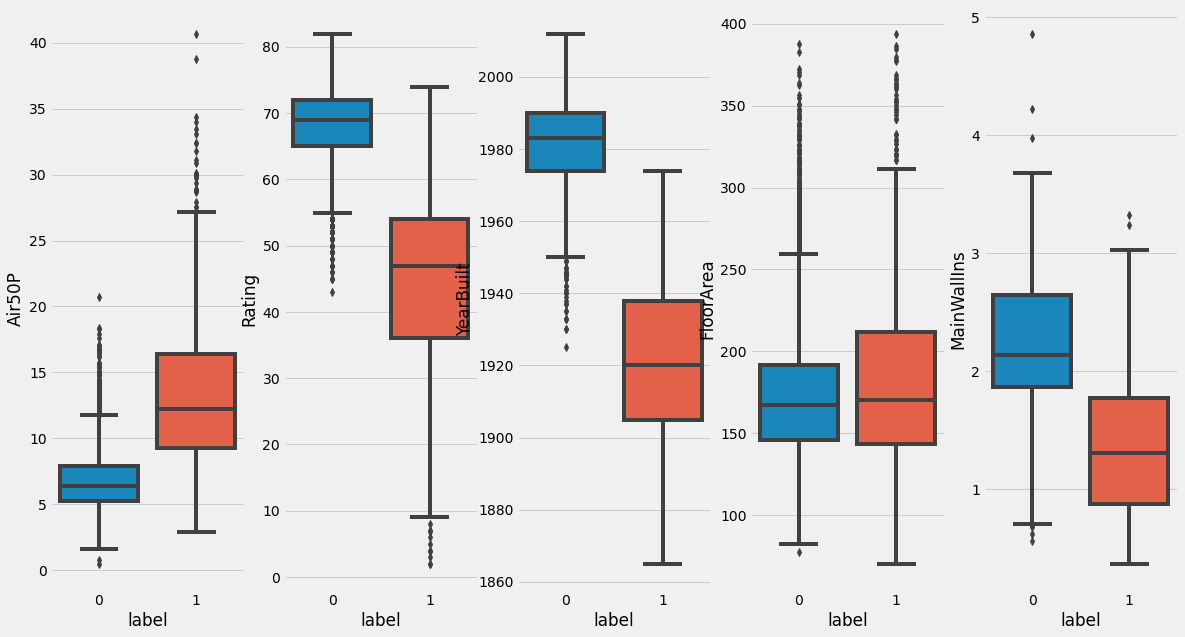

In [118]:
#set up subplot
fig, axes = plt.subplots(1, len(parameters), figsize=(18, 10))

#use a while loop to plot each parameters distribution
i=0
while i != len(parameters):
    
    sns.boxplot(ax=axes[i], x="label", y= parameters[i], data=clusters)
    i=i+1